<div align='center'>
<font size="5"><strong>Wikipedia Pageviews Project</strong></font>
<br />
<i>Netanel Madmoni</i>
<br />
<strong><i><large>Part 2: Pattern Classification</large></i></strong>
</div>


----------------

In [ ]:
# imports
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import json
import seaborn as sns
from rich import print
import time
from numba import njit
import seaborn as sns

sns.set_style('dark')

load_dotenv()


## Patterns

An interesting area to explore in the page views data set is the unique patterns some pages have.
In this project I decided to focus on the following patterns:
* *One-hit wonder pattern* - a term from the music industry, where a band or an individual become popular due to a single going viral. In this work I am borrowing this term to describe a page of a person that received one big "peak" of views during the lifetime of the page.
* *Nostalgia pattern* - similar to *one-hit wonder*, but here the page received 2 big "peaks" of views during its lifetime, simulating the process of "nostalgia".
* *Seasonal pattern* - where an entity has at least one strong seasonal components in the views its page receives.
* *Rising pattern* - where an entity has an upward trend in its views over time.
* *Fading pattern* - where an entity has an downward trend in its views over time.
* *Constant* - where an entity has no particular pattern in its page views over time.

Below is a visualization of each pattern.

For more details on the classification and the patterns, please refer to the accompanying written report.

In this notebook:
1. I'll classify each entity to have one pattern.
2. I'll analyze the distribution of patterns.

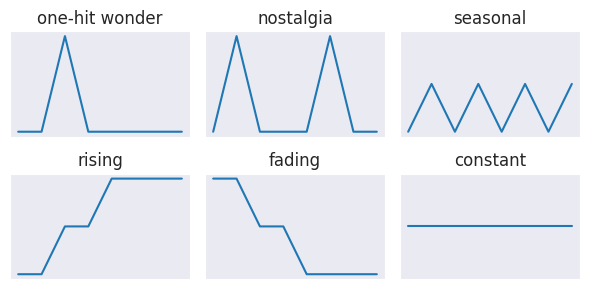

In [15]:
def draw_patterns():
    patterns = {
        'one-hit wonder': [0, 0, 2, 0, 0, 0, 0, 0],
        'nostalgia': [0, 2, 0, 0, 0, 2, 0, 0],
        'seasonal': [0, 1, 0, 1, 0, 1, 0, 1],
        'rising': [0, 0, 1, 1, 2, 2, 2, 2],
        'fading': [2, 2, 1, 1, 0, 0, 0, 0],
        'constant': [1, 1, 1, 1, 1, 1, 1, 1],
        
    }

    fig, axs = plt.subplots(2, len(patterns) // 2, figsize=(len(patterns), 3), sharex=True, sharey=True)
    for (name, pattern), ax in zip(patterns.items(), axs.ravel()):
        sns.lineplot(pattern, ax=ax)
        ax.set(title=name, xticklabels='', yticklabels='')
    plt.tight_layout()
    plt.show()

draw_patterns()

# Reading the Data

In [ ]:
RAW_DATA_DIR = Path(os.getenv('RAW_DATA_DIR'))
PROCESSED_DATA_DIR = Path(os.getenv('PROCESSED_DATA_DIR'))
RANDOM_SEED = 42

In [ ]:
views_df = pl.read_parquet(PROCESSED_DATA_DIR / 'pageviews_all.parquet')
info_df = pl.read_parquet(PROCESSED_DATA_DIR / 'people_data_all.parquet')

In [ ]:
views_df

title,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,…,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Neophyte_II_of…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,14,17,26,10,17,24,29,32,51,20,36,46,32,119,27,32,18,26,22,30,30,26,35,33,33,26,25,24,29,44,23,25
"""Olivia_Giovett…",26,34,52,20,41,40,19,21,27,23,32,21,32,29,57,47,31,21,24,15,42,17,45,30,25,34,36,22,22,22,16,28,30,34,22,19,…,39,30,32,34,37,29,14,26,24,36,39,35,20,63,33,39,19,19,30,20,14,21,35,52,25,25,33,20,18,22,31,26,16,20,59,41,19
"""Alexander_Gran…",9,48,24,23,32,24,12,20,19,7,8,14,18,27,11,23,12,19,15,17,11,13,26,14,16,18,13,20,13,26,16,19,32,14,18,12,…,5,13,9,12,11,9,14,19,9,7,5,11,4,11,9,7,9,9,4,5,12,72,6,10,10,10,2,7,10,7,2,7,4,9,10,1,5
"""Bernard_H._Rae…",17,16,21,20,19,18,10,9,17,5,8,10,5,28,19,11,17,14,13,19,16,13,24,18,10,10,14,13,14,19,5,15,26,12,13,10,…,2,1,4,1,5,5,3,5,2,2,3,4,null,12,4,3,2,1,4,null,1,3,8,6,3,1,5,1,3,5,7,3,1,2,null,1,2
"""Leigh_Magar""",47,46,64,36,56,45,41,26,30,48,15,26,19,38,28,38,37,51,24,36,17,15,45,39,26,22,21,14,19,23,16,32,36,21,18,20,…,8,8,9,13,6,3,12,13,12,5,8,8,11,3,9,8,13,13,9,20,9,8,14,27,14,13,20,13,10,9,5,9,9,8,5,10,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Edgar_Dibden""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,16,6,10,6,7,4,2
"""David_Mulready…",56,51,78,51,54,59,36,44,31,33,29,29,29,54,44,45,23,36,38,35,32,31,42,27,44,33,27,52,29,41,21,36,47,64,37,30,…,16,21,27,33,15,22,31,15,25,16,25,12,25,27,31,18,27,25,20,21,34,15,16,14,15,19,26,19,18,12,7,19,12,14,14,7,6
"""Bruno_Riem""",40,29,34,17,31,29,22,31,14,8,8,16,13,16,7,17,24,16,20,14,14,7,23,16,25,14,13,15,13,20,10,17,31,14,13,12,…,4,9,2,4,5,4,7,8,6,7,8,5,5,4,4,7,2,5,4,11,2,4,5,5,3,5,2,2,4,3,7,5,4,3,3,1,2


In [ ]:
info_df

wikidata_code,birth,death,gender,level1_main_occ,name,un_subregion,level2_main_occ,level3_main_occ,bigperiod_birth,bigperiod_death,sum_visib_ln_5criteria,ranking_visib_5criteria,citizenship_1_b,un_region,bplo1,dplo1,bpla1,dpla1,en_label,en_description,worked_at,educated_at,instrument,genre,birth_month,count_gender,count_instrument,count_worked_at,count_country_of_citizenship,count_educated_at,count_occupation,count_genre
str,i64,i64,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,str,str,list[str],list[str],list[str],list[str],str,u32,u32,u32,u32,u32,u32,u32
"""Q1000005""",1860,1927,"""Male""","""Culture""","""Karel_Matěj_Ča…","""Western Europe…","""Culture-core""","""writer""","""4.Mid Modern P…","""5.Contemporary…",23.98061,131428.0,"""Czech_Republic…","""Europe""",12.929798,14.421389,49.440605,50.087502,"""Karel Matěj Ča…","""Czech writer a…",[],[],[],[],"""02""",1,0,0,1,0,4,0
"""Q100005""",1922,1951,"""Male""","""Culture""","""Tadeusz_Borows…","""Eastern Europe…","""Culture-core""","""writer""","""5.Contemporary…","""5.Contemporary…",28.841227,21473.5,"""Poland""","""Europe""",28.657778,21.01111,50.254444,52.23,"""Tadeusz Borows…","""Polish writer …",[],"[""University of Warsaw""]",[],[],"""11""",1,0,0,1,1,5,0
"""Q1000051""",1884,1962,"""Male""","""Leadership""","""Joseph_C._O'Ma…","""Northern Ameri…","""Politics""","""politician""","""4.Mid Modern P…","""5.Contemporary…",23.15431,170792.0,"""US""","""America""",-71.033333,-77.094643,42.391666,38.984825,"""Joseph C. O'Ma…","""American journ…",[],"[""Georgetown University Law Center"", ""Columbia University""]",[],[],"""11""",1,0,0,1,2,3,0
"""Q1000053""",1962,null,"""Male""","""Leadership""","""Vasily_Nebenzy…","""Eastern Europe…","""Administration…","""diplomat""","""5.Contemporary…","""Missing""",25.141882,230781.0,"""Russia""","""Europe""",44.514721,null,48.708611,null,"""Vasily Nebenzy…","""Russian diplom…","[""United Nations""]","[""Moscow State Institute of International Relations""]",[],[],"""02""",1,0,1,2,1,2,0
"""Q1000061""",1940,null,"""Male""","""Leadership""","""Valentyn_Symon…","""Eastern Europe…","""Politics""","""politician""","""5.Contemporary…","""Missing""",23.340572,219961.0,"""Ukraine""","""Europe""",30.73262,null,46.47747,null,"""Valentyn Symon…","""Ukrainian stat…","[""State University of Trade and Economics""]","[""Odesa State Academy of Civil Engineering and Architecture""]",[],[],"""07""",1,0,1,1,1,2,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q999994""",1988,null,"""Male""","""Sports/Games""","""Mitja_Mežnar""","""Southern Europ…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",21.543238,350041.5,"""Slovenia""","""Europe""",14.35561,null,46.238869,null,"""Mitja Mežnar""","""Slovenian ski …",[],[],[],[],"""06""",1,0,0,1,0,1,0
"""Q999995""",1987,null,"""Male""","""Sports/Games""","""Martin_Cikl""","""Western Europe…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",21.71133,339942.5,"""Czech_Republic…","""Europe""",14.618354,null,50.911613,null,"""Martin Cikl""","""Czech ski jump…",[],[],[],[],"""08""",1,0,0,1,0,1,0
"""Q999997""",1984,null,"""Male""","""Sports/Games""","""Vincent_Descom…","""Western Europe…","""Sports/Games""","""ski""","""5.Contemporary…","""Missing""",24.453411,154890.0,"""France""","""Europe""",6.868889,null,45.922222,null,"""Vincent Descom…","""French ski jum…",[],[],[],[],"""01""",1,0,0,1,0,2,0


# Determining the Pattern for each Entity

The tools to discover each pattern are as follows:
* *One-hit wonder*, *Nostalgia* -- Symbolic Aggregate ApproXimation (SAX).
* *Seasonal* -- autocorrelation function.
* *Rising*, *Fading* -- Linear regression.
* *Constant* -- anything that doesn't fall into one of the other categories.

Tools are purposely selected to be simple and fast on big data calculations.

Please refer to the accompanying written report for a more detailed explanation of the classification process.

In [81]:
from pyts.approximation import SymbolicAggregateApproximation, PiecewiseAggregateApproximation
from pyts.decomposition import SingularSpectrumAnalysis
from scipy import stats
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer
from statsmodels.tsa.stattools import acf

SAX: https://jmotif.github.io/sax-vsm_site/morea/algorithm/SAX.html

One-hit wonder, nostalgia

In [452]:
@njit
def _count_clusters(x_sax: np.ndarray, d: int):
    if x_sax.ndim != 1:
        raise ValueError('array must be 1d')
    nonzero_count = np.count_nonzero(x_sax) 
    if nonzero_count in (0, 1):
        return nonzero_count

    # Calculate the difference between consecutive indices where 1s occur
    diff = np.diff(np.where(x_sax)[0])

    # Count the number of clusters by checking where the difference is greater than d
    num_clusters = np.sum(diff > d)

    # Add 1 to account for the last cluster
    num_clusters += 1 if len(diff) > 0 else 0

    return num_clusters


def _count_clusters_2d(X_sax: np.ndarray, d: int):
    return np.apply_along_axis(_count_clusters, d=d, arr=X_sax, axis=1).reshape(-1, 1)

def is_one_hit_wonder(X_sax, d: int):
    return _count_clusters_2d(X_sax, d) == 1

def is_nostalgia(X_sax, d: int):
    return _count_clusters_2d(X_sax, d) == 2

Seasonality

In [276]:
# def _find_seasonality(x: np.ndarray, d: int, fitter):
#     if x.ndim != 1:
#         raise ValueError('array must be 1d')
#     fitter.fit(x)
#     significant_sp = fitter.get_fitted_params()['sp_significant']
#     if len(significant_sp) > 0:
#         sp_idx = np.argwhere(np.array(significant_sp) > d)
#         if len(sp_idx) > 0:
#             return significant_sp[sp_idx[0]]
#     return None

# def find_seasonality_2d(X: np.ndarray, d: int):
#     fitter = Differencer() * SeasonalityACF()
#     return np.apply_along_axis(_find_seasonality, d=d, fitter=fitter, arr=X, axis=1).reshape(-1, 1)

# def is_seasonal(seasonality: np.ndarray):
#     return seasonality.astype(bool)

In [435]:
def _find_seasonality(x, d):
    lower_bounds = acf(np.diff(x), qstat=True, missing='drop', alpha=.05)[1][d + 1:, 0]
    if lower_bounds.max() < 0:
        return None
    most_significant = (np.argsort(-lower_bounds) + d + 1)[0]
    return most_significant

def find_seasonality_2d(X, d):
    return np.apply_along_axis(_find_seasonality, d=d, arr=X, axis=1).reshape(-1, 1).astype(float)

def is_seasonal(seasonality: np.ndarray):
    return seasonality.astype(bool)

Linear trend

In [211]:
def regression_per_row(X: np.ndarray):
    # normalize X
    X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
    
    # X range (time)
    m = X.shape[1] - 1
    X_range = np.arange(X.shape[1])
    X_range_mean = m / 2
    
    # slopes, intercepts, residuals
    mean = X.mean(axis=1, keepdims=True)
    slopes = ((X - mean).dot(X_range - X_range_mean) / (m * np.var(X_range))).reshape(-1, 1)
    intercepts = mean - slopes * X_range_mean
    residuals = X - (slopes * X_range + intercepts)
    
    # rss, tss, r2
    rss = np.sum(np.square(residuals), axis=1, keepdims=True)
    tss = np.sum(np.square(X - mean), axis=1, keepdims=True)
    r2s = 1 - rss / tss
    
    # pvalues
    se = X.std(axis=1, keepdims=True) / np.sqrt(np.sum(np.square(X_range - X_range_mean)))
    statistics = slopes / se
    pvs = 2 * (1 - stats.t.cdf(np.abs(statistics), m))
    
    return slopes, intercepts, r2s, pvs
    
def is_rising(slopes: np.ndarray, pvs: np.ndarray):
    return np.logical_and(slopes > 0, pvs > 0.05)

def is_fading(slopes: np.ndarray, pvs: np.ndarray):
    return np.logical_and(slopes < 0, pvs > 0.05)

In [457]:
def get_patterns(views_df: pl.DataFrame, d: int):
    sax_transformer = SymbolicAggregateApproximation(n_bins=2, alphabet='ordinal', strategy='uniform')

    X = views_df.drop('title').fill_null(0).to_numpy()
    X_sax = sax_transformer.transform(X)

    one_hit_wonder = is_one_hit_wonder(X_sax, d)
    nostalgia = is_nostalgia(X_sax, d)
    seasonality = find_seasonality_2d(X, d)
    seasonal = is_seasonal(seasonality)
    slopes, intercepts, r2s, pvs = regression_per_row(X)
    rising = is_rising(slopes, pvs)
    fading = is_fading(slopes, pvs)
    
    return pl.DataFrame([
        views_df['title'],
        pl.Series('is_one_hit_wonder', one_hit_wonder.ravel()),
        pl.Series('is_nostalgia', nostalgia.ravel()),
        pl.Series('seasonality', seasonality.ravel()),
        pl.Series('is_seasonal', seasonal.ravel()),
        pl.Series('is_rising', rising.ravel()),
        pl.Series('is_fading', fading.ravel()),
    ])

patterns_df = get_patterns(views_df, d=3)

In [495]:
patterns_df

title,is_one_hit_wonder,is_nostalgia,seasonality,is_seasonal,is_rising,is_fading
str,bool,bool,f64,bool,bool,bool
"""Neophyte_II_of…",true,false,NaN,false,false,false
"""Olivia_Giovett…",true,false,NaN,false,true,false
"""Alexander_Gran…",false,true,NaN,false,false,false
"""Bernard_H._Rae…",false,false,9.0,true,false,false
"""Leigh_Magar""",false,false,NaN,false,false,false
…,…,…,…,…,…,…
"""Edgar_Dibden""",true,false,NaN,false,false,false
"""David_Mulready…",false,false,NaN,false,false,false
"""Bruno_Riem""",false,false,NaN,false,false,false


In [ ]:
patterns_df.write_parquet(PROCESSED_DATA_DIR / 'views_patterns.parquet')

In [488]:
# TODO make patterns exclusive

In [498]:
people_data_all = pl.read_parquet(PROCESSED_DATA_DIR / 'people_data_all.parquet')
patterns_df = pl.read_parquet(PROCESSED_DATA_DIR / 'views_patterns.parquet')
combined_df = people_data_all.join(patterns_df, left_on='name', right_on='title')

## Preview For Some Entities

In [113]:
X = views_df.filter(pl.col('title').is_in(info_df.filter(pl.col('level2_main_occ') == 'Politics').select('name'))).drop('title').fill_null(0).to_numpy()#.drop_nulls().to_numpy()
rng = np.random.default_rng(RANDOM_SEED)
rng.shuffle(X)

In [116]:
sax_transformer = SymbolicAggregateApproximation(n_bins=2, alphabet='ordinal', strategy='uniform')
X_sax = sax_transformer.transform(X)

paa_transformer = PiecewiseAggregateApproximation(window_size=12, overlapping=False)
X_paa = paa_transformer.transform(X)

ssa_transformer = SingularSpectrumAnalysis(window_size=12, groups='auto')
X_trend, X_seasonal, X_residual = ssa_transformer.fit_transform(X).transpose(1, 0, 2)

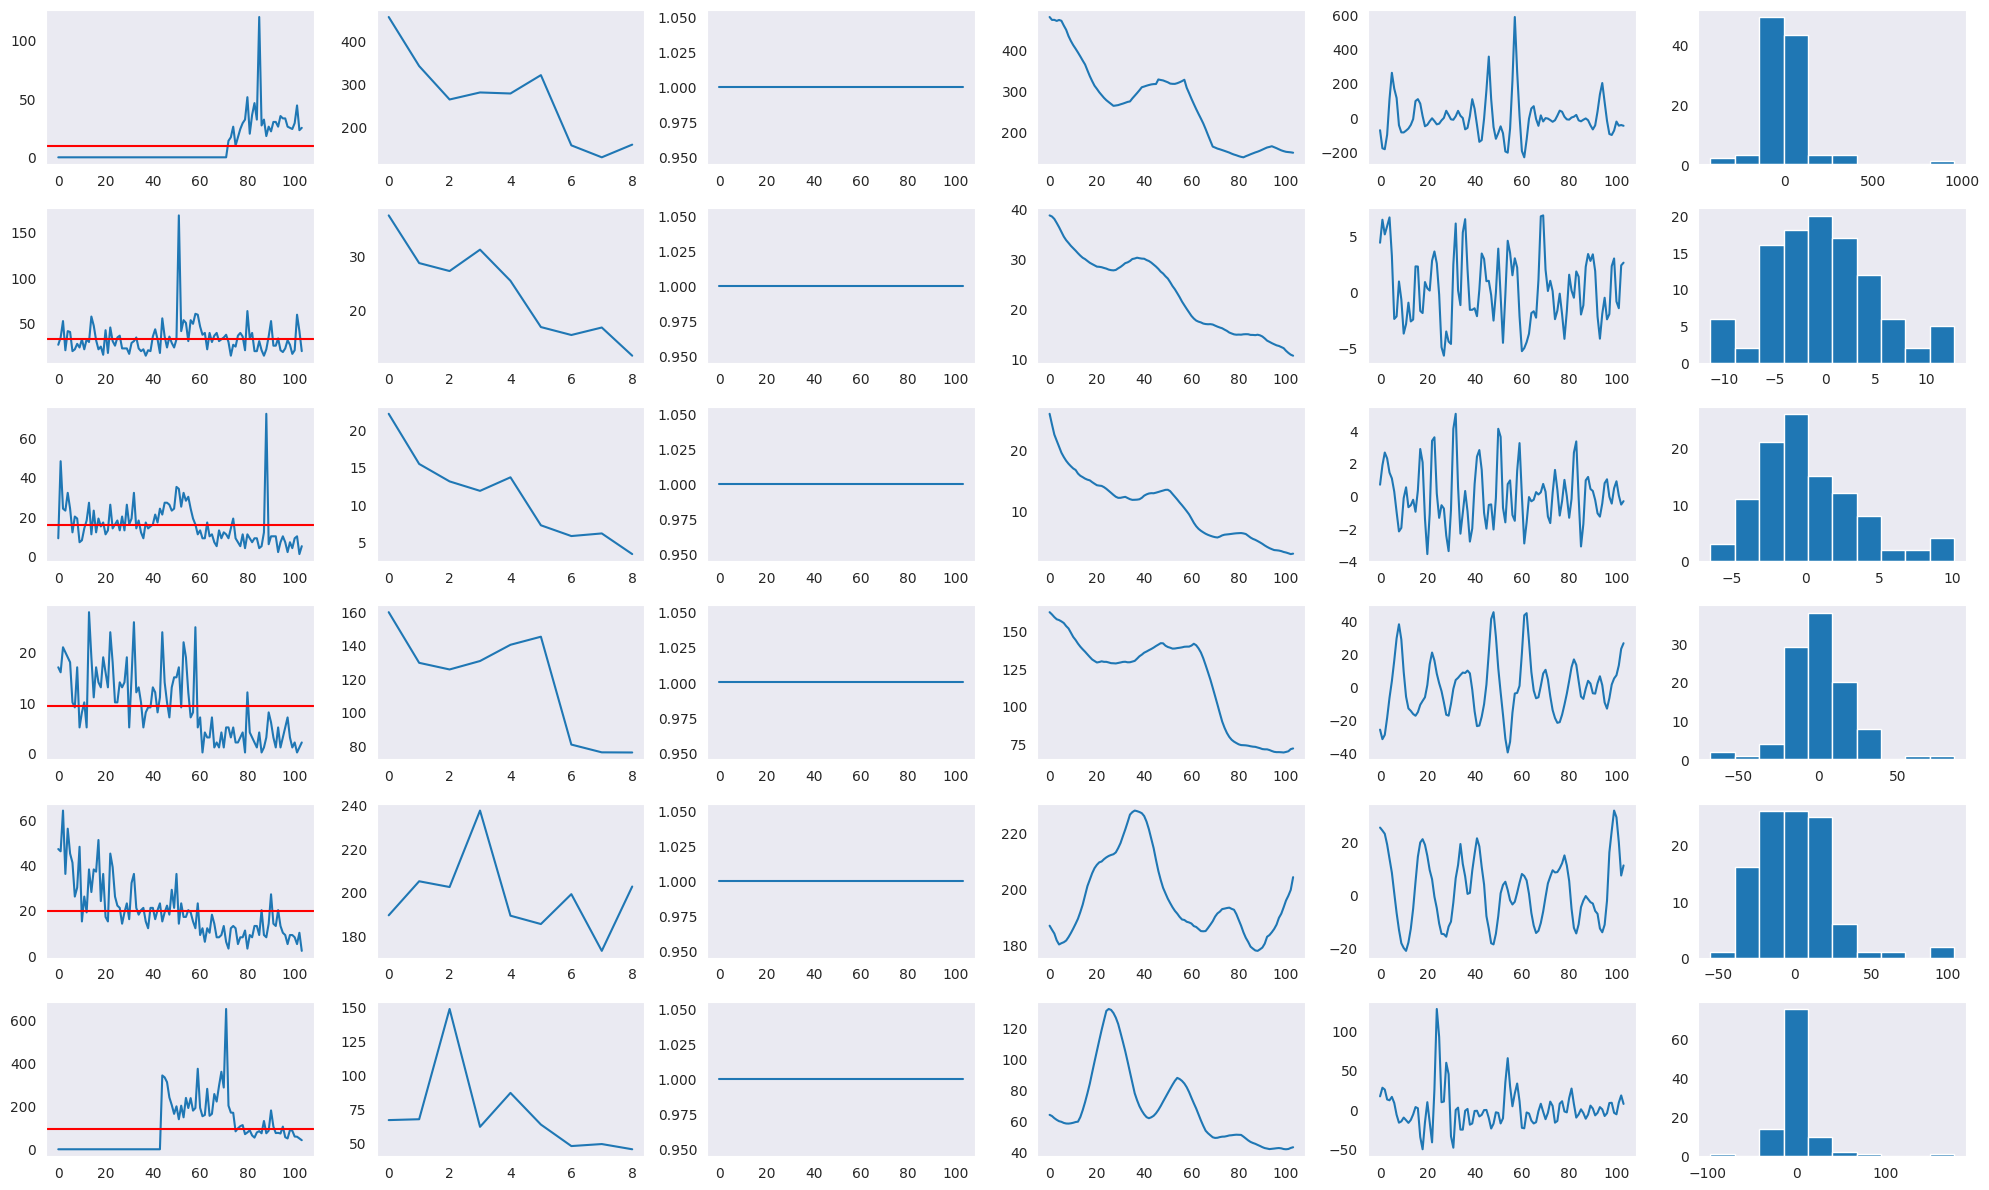

In [345]:
n_to_plot = 6
offset = 0

sample_idx = np.arange(offset, offset + n_to_plot)

fig, axs = plt.subplots(n_to_plot, 6, figsize=(20, n_to_plot * 2))

all_X = zip(X[sample_idx], X_sax[sample_idx], X_paa[sample_idx], X_trend[sample_idx], X_seasonal[sample_idx], X_residual[sample_idx])
for (x, x_sax, x_paa, x_trend, x_seasonal, x_residual), ax in zip(all_X, axs):
    ax[0].plot(x)
    ax[0].axhline(x.mean(), c='red')
    ax[1].plot(x_paa)
    ax[2].plot(x_sax)
    ax[3].plot(x_trend)
    ax[4].plot(x_seasonal)
    ax[5].hist(x_residual)

plt.tight_layout()
plt.show()